In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, bernoulli

import pymc as pm
import arviz as az

In [2]:
# The next libraries are to plot DAGs
import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel

Suppose that we want to infer the direct influence of both parents ($P$) and grandparents ($G$) on the educational achievement of children ($C$). Assume that the grandparents only influence the education of the children trough their parents. But suppose there are unmeasured, common influences on parents and their children, such as neighborhoods, that are not shared by grandparents.

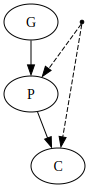

In [3]:
DagChildrenEducation = CausalGraphicalModel(nodes=["G", "P", "C"], edges=[("G", "P"), ("P", "C")], latent_edges=[("P", "C")])
DagChildrenEducation.draw()

In [4]:
ALPHA_LEVEL = 0.11

N = 4000

b_GP = 1.5
b_PC = 1.5
b_U  = 2

In [5]:
U = bernoulli.rvs(size=N, p=0.5)*2 -1
G = norm.rvs(size=N)
P = norm.rvs(size=N, loc=b_GP*G + b_U*U)
C = norm.rvs(size=N, loc=b_PC*P + b_U*U)

Dat = pd.DataFrame(np.array([C, P, G, U]).T, columns=['C', 'P', 'G', 'U'])

We can get the total effect of $G$ in $C$ with the next model.

In [6]:
with pm.Model() as ModelGrandparentsChildren:
    Alpha   = pm.Flat('Alpha')
    Beta_GC = pm.Flat('Beta_GC')
    Sigma   = pm.HalfFlat('Sigma')

    Mu = pm.Deterministic('Mu', Alpha + Beta_GC*G)

    CModel  = pm.Normal('C', mu=Mu, sigma=Sigma, observed=C)

    TraceGrandparentsChildren = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta_GC, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
/home/dmitri/.local/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [7]:
az.summary(TraceGrandparentsChildren, var_names=['Beta_GC', 'Sigma'], hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
Beta_GC,2.187,0.086,2.056,2.325
Sigma,5.317,0.059,5.220,5.409


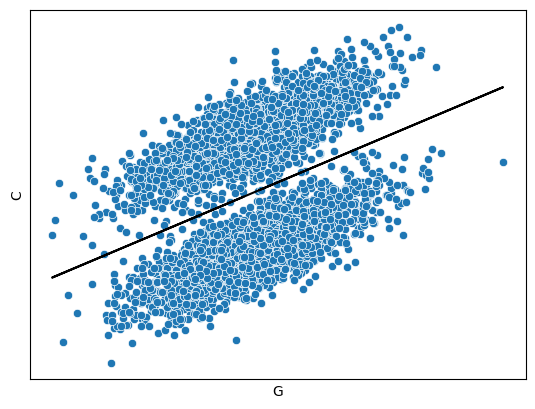

In [8]:
sns.scatterplot(data=Dat, x='G', y='C')

plt.plot(
    Dat['G']
    , TraceGrandparentsChildren.posterior.Mu.mean(('chain', 'draw'))
    , color='k'
)

plt.yticks([])
plt.xticks([])

plt.xlabel('G')
plt.ylabel('C')

plt.savefig("HauntedGInC.png", transparent=True)

Even if we were able to measure $U$, including it in the model we would still be able to get the total effect of $G$ in $H$, because the non-causal path is close.

In [9]:
with pm.Model() as ModelGrandparentsChildrenAdjustU1:
    Alpha   = pm.Flat('Alpha')
    Beta_GC = pm.Flat('Beta_GC')
    Sigma   = pm.HalfFlat('Sigma')

    Mu = pm.Deterministic('Mu', Alpha + Beta_GC*G[U==1])

    CModel  = pm.Normal('C', mu=Mu, sigma=Sigma, observed=C[U==1])

    TraceGrandparentsChildrenAdjustU1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta_GC, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [10]:
with pm.Model() as ModelGrandparentsChildrenAdjustU2:
    Alpha   = pm.Flat('Alpha')
    Beta_GC = pm.Flat('Beta_GC')
    Sigma   = pm.HalfFlat('Sigma')

    Mu = pm.Deterministic('Mu', Alpha + Beta_GC*G[U==-1])

    CModel  = pm.Normal('C', mu=Mu, sigma=Sigma, observed=C[U==-1])

    TraceGrandparentsChildrenAdjustU2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta_GC, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [11]:
az.summary(TraceGrandparentsChildrenAdjustU1, var_names=['Beta_GC', 'Sigma'], hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
Beta_GC,2.284,0.041,2.213,2.346
Sigma,1.807,0.029,1.766,1.858


In [12]:
az.summary(TraceGrandparentsChildrenAdjustU2, var_names=['Beta_GC', 'Sigma'], hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
Beta_GC,2.217,0.040,2.154,2.281
Sigma,1.794,0.028,1.750,1.837


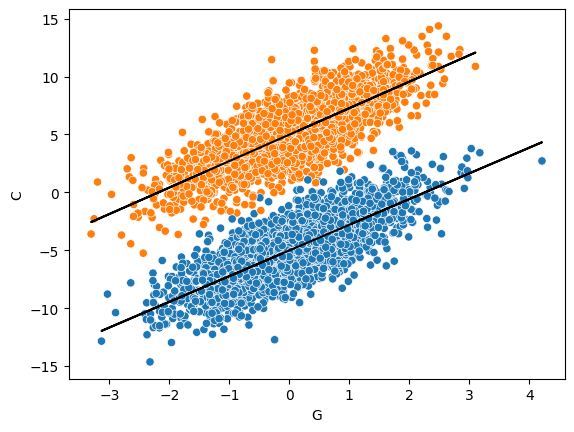

In [13]:
sns.scatterplot(data=Dat, x='G', y='C', hue='U', palette='tab10', legend=False)

plt.plot(
    Dat.loc[Dat['U']==1, 'G']
    , TraceGrandparentsChildrenAdjustU1.posterior.Mu.mean(('chain', 'draw'))
    , color='k'
)

plt.plot(
    Dat.loc[Dat['U']==-1, 'G']
    , TraceGrandparentsChildrenAdjustU2.posterior.Mu.mean(('chain', 'draw'))
    , color='k'
)

plt.xlabel('G')
plt.ylabel('C')

plt.savefig("HauntedGInCAdjustU.png", transparent=True)

But, when we controlled by $P$ the problems arrive! In the next image we select the values of $P$ between the 0.45 and 0.6
quantiles. **We now observe that the apparent effect is now negative!**. This is because conditioning in $P$ closes the causal path and opens the non-causal path

In [14]:
with pm.Model() as ModelGrandparentsChildrenAdjustParent:
    Alpha   = pm.Flat('Alpha')
    Beta_PC = pm.Flat('Beta_PC')
    Beta_GC = pm.Flat('Beta_GC')
    Sigma   = pm.HalfFlat('Sigma')

    CModel  = pm.Normal('C', mu=Alpha + Beta_PC*P + Beta_GC*G, sigma=Sigma, observed=C)

    ModelGrandparentsChildrenAdjustParent = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta_PC, Beta_GC, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


In [15]:
az.summary(ModelGrandparentsChildrenAdjustParent, hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
Alpha,-0.030,0.021,-0.064,0.003
Beta_PC,2.306,0.010,2.290,2.320
Beta_GC,-1.226,0.026,-1.266,-1.184
Sigma,1.352,0.015,1.330,1.376


For example, in the next model we select the observations where $P$ is between the quantile 0.45 and 0.55.

In [16]:
Dat['Selected'] = (P>np.quantile(P, 0.45)) & (P<np.quantile(P, 0.55))

In [17]:
with pm.Model() as ModelGrandparentsChildrenAdjustP:
    Alpha   = pm.Flat('Alpha')
    Beta_GC = pm.Flat('Beta_GC')
    Sigma   = pm.HalfFlat('Sigma')

    Mu = pm.Deterministic('Mu', Alpha + Beta_GC*Dat.loc[Dat['Selected']==1, 'G'])

    CModel  = pm.Normal('C', mu=Mu, sigma=Sigma, observed=Dat.loc[Dat['Selected']==1, 'C'])

    TraceGrandparentsChildrenAdjustP = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta_GC, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [18]:
az.summary(TraceGrandparentsChildrenAdjustP, var_names=['Beta_GC', 'Sigma'], hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
Beta_GC,-1.589,0.079,-1.714,-1.461
Sigma,1.663,0.060,1.564,1.756


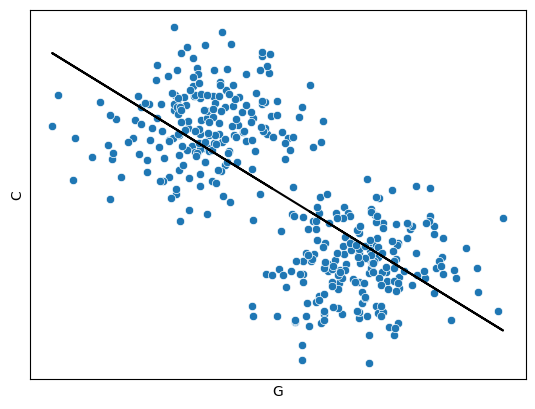

In [19]:
sns.scatterplot(data=Dat[Dat['Selected']==1], x='G', y='C')

plt.plot(
    Dat.loc[Dat['Selected']==1, 'G']
    , TraceGrandparentsChildrenAdjustP.posterior.Mu.mean(('chain', 'draw'))
    , color='k'
)

plt.yticks([])
plt.xticks([])

plt.xlabel('G')
plt.ylabel('C')

plt.savefig("HauntedGInCAdjustP.png", transparent=True)

Finally, note that if we adjust by $P$ and $U$, we get the direct effect of $G$ in $C$, which in this case is zero, since all the effect of $G$ in $C$ is through $P$

In [20]:
with pm.Model() as ModelGrandparentsChildrenAdjustPAdjustU1:
    Alpha   = pm.Flat('Alpha')
    Beta_GC = pm.Flat('Beta_GC')
    Sigma   = pm.HalfFlat('Sigma')

    Mu = pm.Deterministic('Mu', Alpha + Beta_GC*Dat.loc[(Dat['Selected']==1) & (Dat['U']==1), 'G'])

    CModel  = pm.Normal('C', mu=Mu, sigma=Sigma, observed=Dat.loc[(Dat['Selected']==1) & (Dat['U']==1), 'C'])

    ModelGrandparentsChildrenAdjustPAdjustU1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta_GC, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [21]:
with pm.Model() as ModelGrandparentsChildrenAdjustPAdjustU2:
    Alpha   = pm.Flat('Alpha')
    Beta_GC = pm.Flat('Beta_GC')
    Sigma   = pm.HalfFlat('Sigma')

    Mu = pm.Deterministic('Mu', Alpha + Beta_GC*Dat.loc[(Dat['Selected']==1) & (Dat['U']==-1), 'G'])

    CModel  = pm.Normal('C', mu=Mu, sigma=Sigma, observed=Dat.loc[(Dat['Selected']==1) & (Dat['U']==-1), 'C'])

    ModelGrandparentsChildrenAdjustPAdjustU2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Alpha, Beta_GC, Sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [22]:
az.summary(ModelGrandparentsChildrenAdjustPAdjustU1, var_names=['Beta_GC', 'Sigma'], hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
Beta_GC,0.252,0.139,0.041,0.481
Sigma,1.129,0.058,1.044,1.226


In [23]:
az.summary(ModelGrandparentsChildrenAdjustPAdjustU2, var_names=['Beta_GC', 'Sigma'], hdi_prob=1-ALPHA_LEVEL, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
Beta_GC,0.201,0.142,-0.010,0.450
Sigma,1.123,0.056,1.032,1.209


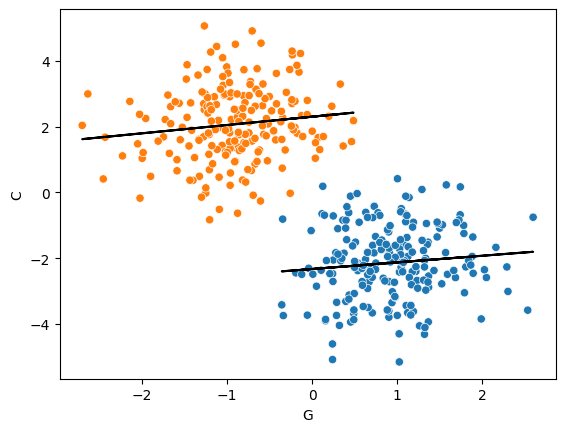

In [24]:
sns.scatterplot(data=Dat[Dat['Selected']==1], x='G', y='C', hue='U', palette='tab10', legend=False)

plt.plot(
    Dat.loc[(Dat['Selected']==1) & (Dat['U']==1), 'G']
    , ModelGrandparentsChildrenAdjustPAdjustU1.posterior.Mu.mean(('chain', 'draw'))
    , color='k'
)

plt.plot(
    Dat.loc[(Dat['Selected']==1) & (Dat['U']==-1), 'G']
    , ModelGrandparentsChildrenAdjustPAdjustU2.posterior.Mu.mean(('chain', 'draw'))
    , color='k'
)

plt.xlabel('G')
plt.ylabel('C')

plt.savefig("HauntedGInCAdjustUAdjustP.png", transparent=True)